# **VGG16-Transfer Learning On Custom Dataset: Rice Plant Pathology.**

The custom dataset comprises of paddy leaf images of 5 different classes.
1. Bacterialblight
2. BrownSpot
3. Healthy
4. LeafBlast
5. Tungro

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Set the image size as per the VGG16 archetecture
IMAGE_SIZE = [224, 224]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive'

MyDrive


In [ ]:
#Give dataset path
train_path = '/content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/train'
validation_path = '/content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/validation'

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:

print('total images for training :', count(train_path))
print('total images for validation :', count(validation_path))

total images for training : /content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/train : 2759files
total images for validation : /content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/validation : 576files


In [ ]:
folders = glob('/content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/train/*')
print(len(folders))


5


In [ ]:
model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(len(folders), activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessin

In [ ]:
class_subset = sorted(os.listdir('/content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/train/'))[:5] # Using only the first 10 classes
print(class_subset)
traingen = train_generator.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=5)

validgen = train_generator.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=4)

testgen = test_generator.flow_from_directory(validation_path,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=4)

['Bacterialblight', 'BrownSpot', 'Healthy', 'LeafBlast', 'Tungro']
Found 2347 images belonging to 5 classes.
Found 412 images belonging to 5 classes.
Found 576 images belonging to 5 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
optim_1 = Adam(learning_rate=0.001)
#n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best_50epochs.hdf5',
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=2)

# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


vgg_history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1], 
                            verbose=1)

Epoch 1/50
36/36 [==============================] - 938s 25s/step - loss: 8.6924 - accuracy: 0.5418 - val_loss: 0.9437 - val_accuracy: 0.7188

Epoch 00001: val_accuracy improved from -inf to 0.71875, saving model to tl_model_v1.weights.best_50epochs.hdf5
Epoch 2/50
36/36 [==============================] - 139s 4s/step - loss: 0.7259 - accuracy: 0.7328 - val_loss: 0.5715 - val_accuracy: 0.7969

Epoch 00002: val_accuracy improved from 0.71875 to 0.79688, saving model to tl_model_v1.weights.best_50epochs.hdf5
Epoch 3/50
36/36 [==============================] - 137s 4s/step - loss: 0.5617 - accuracy: 0.7845 - val_loss: 0.4228 - val_accuracy: 0.8516

Epoch 00003: val_accuracy improved from 0.79688 to 0.85156, saving model to tl_model_v1.weights.best_50epochs.hdf5
Epoch 4/50
36/36 [==============================] - 139s 4s/step - loss: 0.5092 - accuracy: 0.8012 - val_loss: 0.5198 - val_accuracy: 0.8073

Epoch 00004: val_accuracy did not improve from 0.85156
Epoch 5/50
36/36 [================

In [ ]:
import numpy as np
# Generate predictions
model.load_weights('tl_model_v1.weights.best_50epochs.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 89.24%


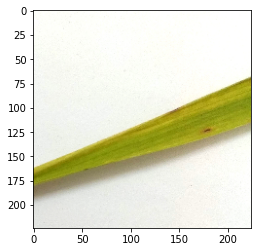

In [ ]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('/content/drive/MyDrive/My_Learnings/Transfer_Learning/RiceDiseaseDataset/validation/BrownSpot/IMG_20190420_194501.jpg', target_size=(224, 224))
plt.imshow(image )
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
yhat = model.predict(image)
print(yhat)

[[1.9657017e-14 9.9896562e-01 1.0301921e-03 4.2341298e-06 1.3601713e-18]]


In [ ]:
# convert the probabilities to class labels
label = np.argmax(yhat)
# retrieve the most likely result, e.g. highest probability
#label = label[0][0]
# print the classification
print(class_subset[label] )

BrownSpot
